In [36]:
import numpy as np
# from dolfin import *
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the matrix and vector from the files
Ak_np = np.load("Ak.npy")
L_np = np.load("L.npy")

# Initial guess (zero vector)
x0 = np.zeros(len(L_np))

# Set tolerance and maximum iterations
tol = 1e-8
max_iter = 1000

In [37]:
# Define the grid for the unit square
n = 20
x_range = np.arange(0, 1 + 1 / n, 1 / n)
y_range = np.arange(0, 1 + 1 / n, 1 / n)
xy = np.array(np.meshgrid(x_range, y_range)).T.reshape(-1, 2)

# Simulate coord_map for mapping solution to mesh (based on finite element DoFs)
# coord_map should be replaced with the actual DoF coordinates from your FEM solver
coord_map = xy.copy()

In [38]:
# Conjugate Residual Method with Residual Tracking
def conjugate_residual(A, x0, b, max_iter, tol):
    x = x0.copy()
    r = b - A @ x0
    p = r.copy()
    Ap = A @ p
    residuals = [np.linalg.norm(r)]  # Track initial residual norm

    for k in tqdm(range(max_iter)):
        Ar = A @ r
        alpha = (np.transpose(r) @ Ar) / (np.transpose(Ap) @ Ap)
        x_new = x + alpha * p

        # Check for convergence
        if np.linalg.norm(x_new - x) / np.linalg.norm(x_new) < tol:
            residuals.append(np.linalg.norm(b - A @ x_new))
            return x_new, residuals

        r_new = r - alpha * Ap
        residuals.append(np.linalg.norm(r_new))  # Track residual norm
        Ar_new = A @ r_new
        beta = (np.transpose(r_new) @ Ar_new) / (np.transpose(r) @ Ar)
        p_new = r_new + beta * p
        Ap_new = Ar_new + beta * Ap

        x, r, p, Ap = x_new, r_new, p_new, Ap_new

    return x, residuals

    
# Solve using the Conjugate Gradient method with convergence tracking
def conjugate_gradient(A, b, x, tol, max_iter):
    r = b - A @ x
    residuals = [np.linalg.norm(r)]
    if residuals[-1] < tol:
        return x, residuals
    p = r.copy()
    r_old = np.transpose(r) @ r

    for k in range(max_iter):
        alpha = r_old / (np.transpose(p) @ (A @ p))
        x = x + alpha * p
        r = r - alpha * (A @ p)
        residuals.append(np.linalg.norm(r))

        if residuals[-1] < tol:
            break

        r_new = np.transpose(r) @ r
        beta = r_new / r_old
        p = r + beta * p
        r_old = r_new

    return x, residuals

In [32]:
solution_cg,residuals = conjugate_gradient(Ak_np, L_np, x0, tol, max_iter)
# Map the solution to the mesh grid
u_reshaped = np.zeros((n + 1) * (n + 1))

for i, coord in enumerate(coord_map):
    for j, xy_val in enumerate(xy):
        if np.allclose(coord, xy_val):
            u_reshaped[j] = solution_cg[i]

u_reshaped = u_reshaped.reshape(n + 1, n + 1)


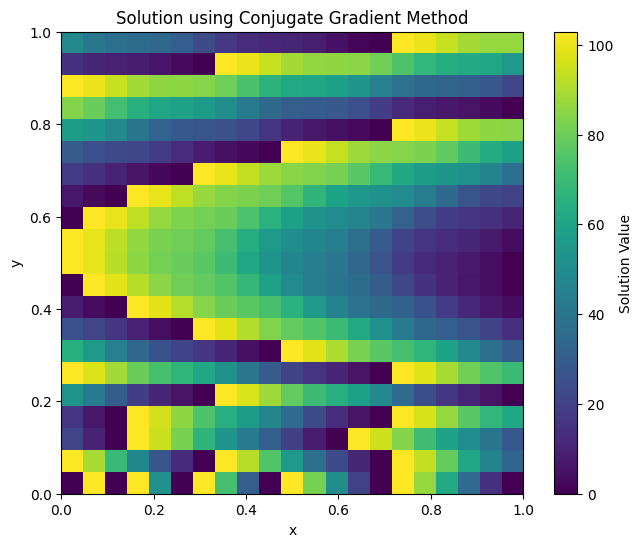

In [33]:
# Plot the solution using imshow
plt.figure(figsize=(8, 6))
plt.imshow(u_reshaped, extent=[0, 1, 0, 1], origin="lower", cmap="viridis")
plt.colorbar(label="Solution Value")
plt.title("Solution using Conjugate Gradient Method")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

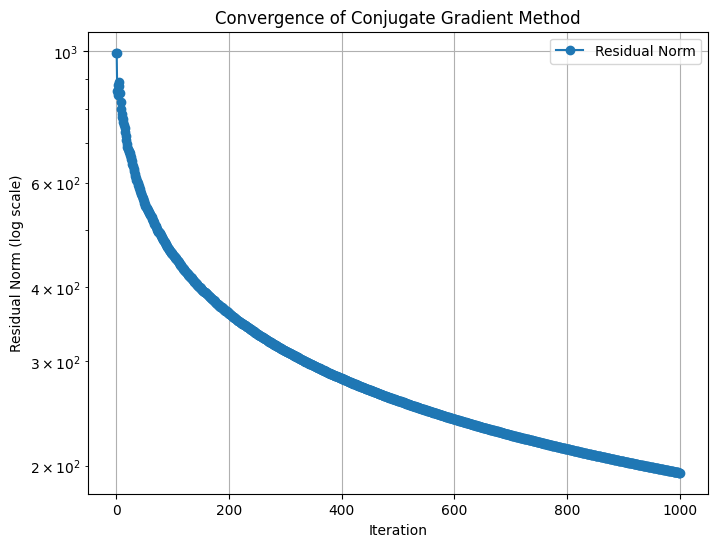

In [34]:
# Plot the convergence of residuals
plt.figure(figsize=(8, 6))
plt.semilogy(residuals, marker="o", label="Residual Norm")
plt.title("Convergence of Conjugate Gradient Method")
plt.xlabel("Iteration")
plt.ylabel("Residual Norm (log scale)")
plt.legend()
plt.grid(True)
plt.show()

In [41]:
# Solve the system using the conjugate residual method
solution_cr, residuals = conjugate_residual(Ak_np, x0, L_np, max_iter, tol)

# Map the solution to the mesh grid
u_reshaped_res = np.zeros((n + 1) * (n + 1))

for i, coord in enumerate(coord_map):
    for j, xy_val in enumerate(xy):
        if np.allclose(coord, xy_val):
            u_reshaped_res[j] = solution_cr[i]

u_reshaped_res = u_reshaped_res.reshape(n + 1, n + 1)

100%|██████████| 1000/1000 [01:07<00:00, 14.88it/s]


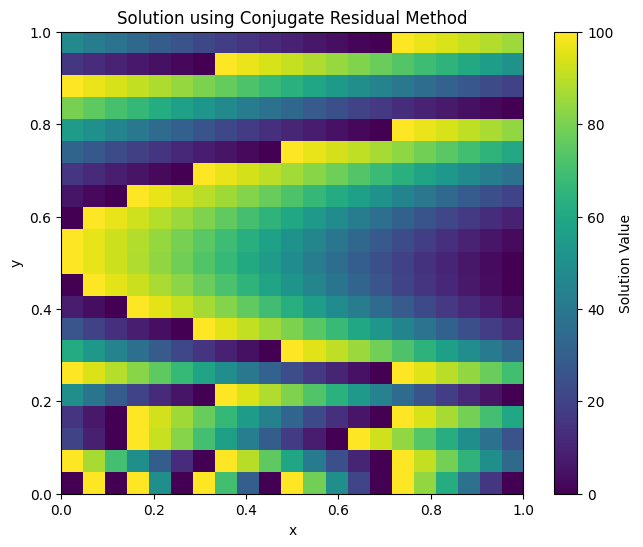

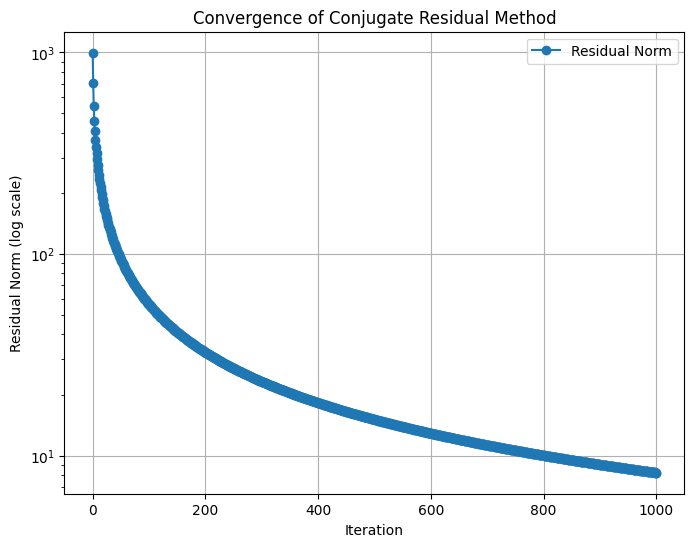

In [42]:
# Plot the solution using imshow
plt.figure(figsize=(8, 6))
plt.imshow(u_reshaped_res, extent=[0, 1, 0, 1], origin="lower", cmap="viridis")
plt.colorbar(label="Solution Value")
plt.title("Solution using Conjugate Residual Method")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Plot the convergence of residuals
plt.figure(figsize=(8, 6))
plt.semilogy(residuals, marker="o", label="Residual Norm")
plt.title("Convergence of Conjugate Residual Method")
plt.xlabel("Iteration")
plt.ylabel("Residual Norm (log scale)")
plt.legend()
plt.grid(True)
plt.show()